# 1. Introducción

El siguiente *notebook* contiene el preprocesamiento y procesamiento del texto correspondiente a la transcripción de la primera cuenta pública presidencial, pronunciada por Patricio Aylwin el 25 de mayo de 1990.

Este corresponde a la realización del trabajo final del módulo 9 'Text Mining' del diplomado de Ciencia de Datos de la Universidad de Santiago de Chile.

Alumno: Martín Bonnefoy Valdés

# 2. Librerías Ocupadas

In [1]:
# Librerías de procesamiento de texto
import pdfplumber
import re
import pandas as pd
import numpy as np
import unidecode
import unicodedata

# Librerías de visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Librerías de procesamiento de lenguaje
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk import SnowballStemmer
nltk.download('punkt')

# Librerías de algoritmos de procesamiento de información
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# 3. Cargado del documento

In [2]:
path = '19900521.pdf'

texto=pdfplumber.open(path)

In [3]:
texto_entero = ''

for pagina in range(0,len(texto.pages)):
    texto_entero += texto.pages[pagina].extract_text()

Se decide trabajar con oraciones en vez de páginas debido a que se considera que la página como tamaño de documento es demasiado grande y heterogéneo.

In [4]:
# Se eliminan los separadores de página.
# Se ocupa iteración con un bucle for debido a que existen casos
# (como años junto a un salto de línea) que necesitan de un término
# regex demasiado complejo

for i in range(1,82):
    filtro = str(i)+ str('\n')
    texto_entero = texto_entero.replace(filtro, '')

In [5]:
# Se eliminan caracteres que afectan resultado de separación por punto en regex

texto_entero = texto_entero.replace('.-', '')
# texto_entero = texto_entero.replace(':', '.')


In [6]:
regex=r'.*?[.]'
oraciones = re.findall(regex, texto_entero, re.DOTALL)
print(len(oraciones))

814


In [7]:
# Se imprime cada oración

for oracion in range(len(oraciones)):
    print(oracion+1, oraciones[oracion], '\n')

1 Legislatura 320ª, Ordinaria
Sesión del Congreso Pleno, en lunes 21 de mayo de 1990
IV. 

2  MENSAJE PRESIDENCIAL
El señor VALDÉS (Presidente) Su Excelencia el
Presidente de la República concurre a esta sesión del
Congreso Pleno para dar cuenta al país del estado
administrativo y político de la nación, de acuerdo con lo
establecido en el inciso final del artículo 24 de la
Constitución Política del Estado. 

3 
Con tal propósito, tiene la palabra Su Excelencia el
Presidente de la República. 

4 
El señor AYLWIN (Presidente de la República)
Conciudadanos del Senado y de la Cámara de Diputados:
Cumplo el deber que la Constitución impone al Presidente
de la República de dar cuenta al país, al menos una vez al
año, “del estado administrativo y político de la nación”. 

5 
Aunque el texto constitucional vigente no prescribe ante
quién ha de rendirse esta cuenta ni la oportunidad de
hacerlo, pienso que lo más adecuado es restablecer la vieja
tradición histórica, que expresamente consagraba l

In [8]:
# Se genera un dataframe a partir de las oraciones

df_oraciones = pd.DataFrame(oraciones, columns=['contenido_crudo'])

df_oraciones.head()

,contenido_crudo
0,"Legislatura 320ª, Ordinaria\nSesión del Congre..."
1,MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presid...
2,"\nCon tal propósito, tiene la palabra Su Excel..."
3,\nEl señor AYLWIN (Presidente de la República)...
4,\nAunque el texto constitucional vigente no pr...


# 4. Preprocesamiento

In [9]:
# Se genera la lista de stopwords en español

stopwords=stopwords.words('spanish')

# Se normaliza el texto eliminando tildes y caracteres latinos

stop_words = []

for word in stopwords:
    word_norm = unicodedata.normalize('NFD', word).encode('ascii', 'ignore').decode("utf-8")
    stop_words.append(word_norm)
    # print(word, word_norm)

In [10]:
# Lematizador

snowball = SnowballStemmer(language='spanish')


def limpieza(texto):
    # Transformaciones realizadas:
    
    texto_norm=texto.lower() # conversión a minúsculas
    texto_norm=texto_norm.strip() # eliminación de espacios iniciales y finales
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8") # conversión de codificación de texto
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm) # se mantienen caracteres alfanuméricos
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = word_tokenize(texto_norm) # tokenización del texto
    texto_norm = [token for token in texto_norm if len(token) > 2] # eliminación de textos de largo 2
    # texto_norm = [token for token in texto_norm if len(token) > 1] # eliminación de textos de largo 1
    
    texto_norm = [word for word in texto_norm if not word in stop_words] # eliminación de stopwords
    
    # Lematización con stemmer de Snowball
    texto_norm=[snowball.stem(word) for word in texto_norm]
    
    return(texto_norm)

In [11]:
df_oraciones['contenido_limpio'] = df_oraciones['contenido_crudo'].apply(lambda x: limpieza(x))

In [12]:
# Se genera una columna del contenido detokenizado

detok=TreebankWordDetokenizer()

df_oraciones['contenido_limpio_detok']=df_oraciones['contenido_limpio'].map(lambda x: detok.detokenize(x))

In [13]:
df_oraciones

,contenido_crudo,contenido_limpio,contenido_limpio_detok
0,"Legislatura 320ª, Ordinaria\nSesión del Congre...","[legislatur, ordinari, sesion, congres, plen, ...",legislatur ordinari sesion congres plen lun may
1,MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presid...,"[mensaj, presidencial, senor, vald, president,...",mensaj presidencial senor vald president excel...
2,"\nCon tal propósito, tiene la palabra Su Excel...","[tal, proposit, palabr, excelent, president, r...",tal proposit palabr excelent president republ
3,\nEl señor AYLWIN (Presidente de la República)...,"[senor, aylwin, president, republ, conciudadan...",senor aylwin president republ conciudadan sen ...
4,\nAunque el texto constitucional vigente no pr...,"[aunqu, text, constitucional, vigent, prescrib...",aunqu text constitucional vigent prescrib rend...
...,...,...,...
809,\n¡Que Dios nos ayude!\n-(Aplausos).,"[dios, ayud, aplaus]",dios ayud aplaus
810,\nEl señor VALDÉS (Presidente) En conformidad ...,"[senor, vald, president, conform, dispuest, ar...",senor vald president conform dispuest articul ...
811,\nSe levanta la sesión.,"[levant, sesion]",levant sesion
812,\n-Se levantó a las 18:42.,[levant],levant


In [14]:
# Se genera una columna para identificar oración

df_oraciones['n_oracion'] = np.arange(len(df_oraciones)) + 1

# 5. Ley de Zipf

In [15]:
# Se genera un dataframe que intersecta cada término con cada oración
doc_term = df_oraciones.explode(column='contenido_limpio')

# Se eliminan las columnas que no se ocupan y se renombra columna de términos
doc_term = doc_term.drop(columns=['contenido_crudo'])
doc_term = doc_term.drop(columns=['contenido_limpio_detok'])
doc_term = doc_term.rename(columns={'contenido_limpio' : 'termino'})

# doc_term.head(10)

In [16]:
doc_term

,termino,n_oracion
0,legislatur,1
0,ordinari,1
0,sesion,1
0,congres,1
0,plen,1
...,...,...
813,manuel,814
813,ocan,814
813,verg,814
813,jef,814


In [17]:
# Se construye el vocabulario

vocabulario = doc_term.groupby(['termino']).count().sort_values(by='n_oracion', ascending=False).reset_index()
vocabulario  = vocabulario.rename(columns={'n_oracion':'frecuencia'})

# Se determina el ranking según frecuencia

vocabulario['ranking']=vocabulario.index+1

# Se agrega frecuencia estimada según fórmula de Ley de Zipf

vocabulario['frecuencia_estimada']=vocabulario.frecuencia[0]/(vocabulario.ranking**2)

vocabulario.head(15)

,termino,frecuencia,ranking,frecuencia_estimada
0,gobiern,98,1,98.000000
1,polit,94,2,24.500000
2,nacional,92,3,10.888889
3,pais,90,4,6.125000
4,sector,87,5,3.920000
5,desarroll,75,6,2.722222
6,chil,69,7,2.000000
7,social,54,8,1.531250
8,recurs,51,9,1.209877
9,hac,48,10,0.980000


In [18]:
vocabulario

,termino,frecuencia,ranking,frecuencia_estimada
0,gobiern,98,1,98.000000
1,polit,94,2,24.500000
2,nacional,92,3,10.888889
3,pais,90,4,6.125000
4,sector,87,5,3.920000
...,...,...,...,...
2436,garant,1,2437,0.000017
2437,ganader,1,2438,0.000016
2438,fundicion,1,2439,0.000016
2439,fugaz,1,2440,0.000016


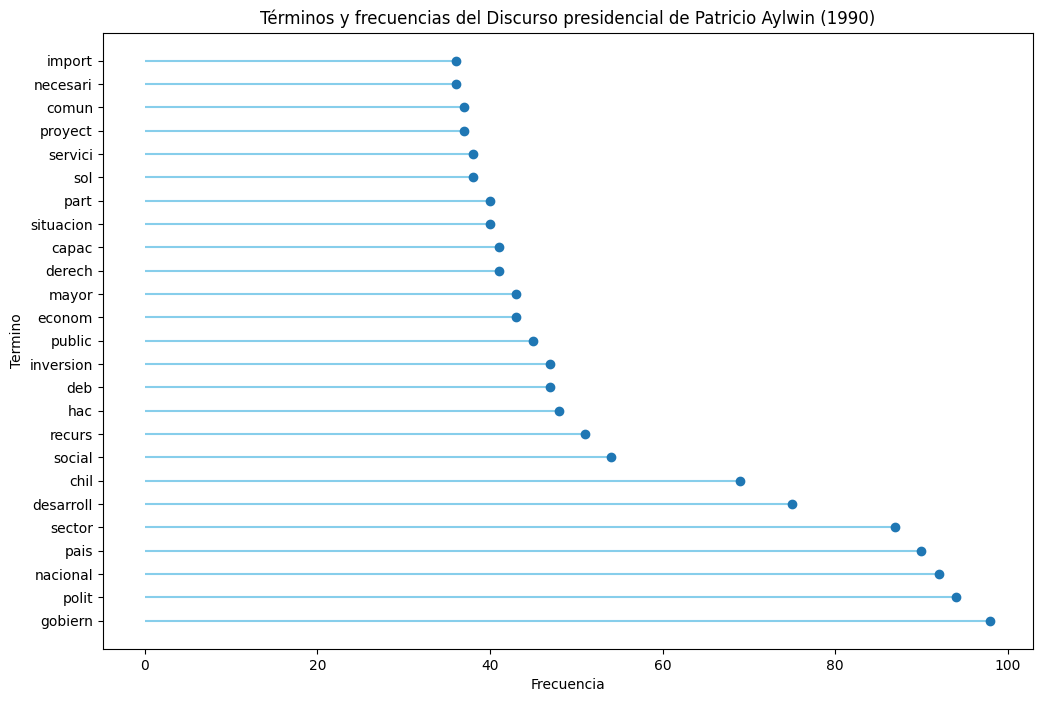

In [19]:
# Gráfico de frecuencias

rango=range(1,len(vocabulario.head(25).index)+1)
plt.figure(figsize = (12,8))
plt.hlines(y=rango, xmin=0, xmax=vocabulario['frecuencia'].head(25), color='skyblue')
plt.plot(vocabulario['frecuencia'].head(25), rango, "o")


plt.yticks(rango, vocabulario['termino'].head(25))
plt.title("Términos y frecuencias del Discurso presidencial de Patricio Aylwin (1990)", loc='center')
plt.xlabel('Frecuencia')
plt.ylabel('Termino')

plt.show()

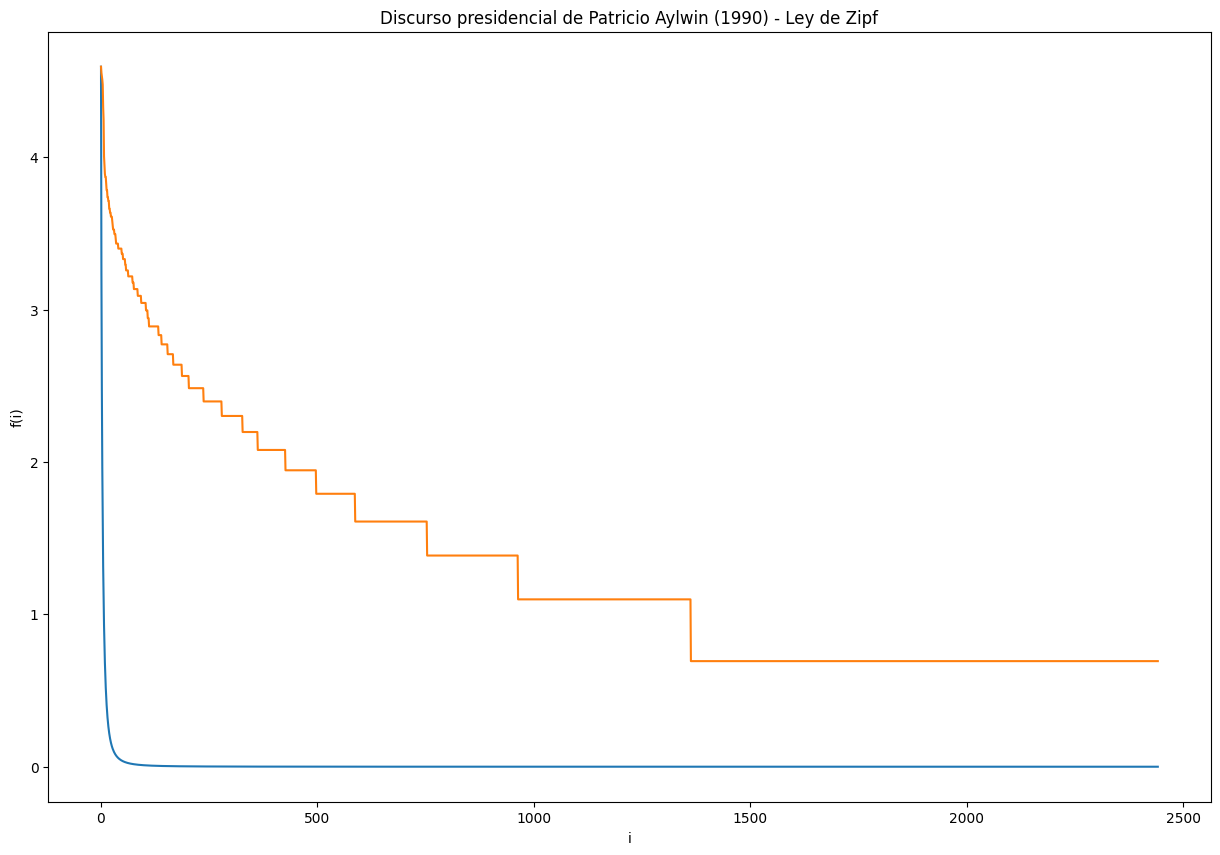

In [20]:
# Gráfico de Ley de Zipf

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(vocabulario.ranking, np.log(vocabulario.frecuencia_estimada+1));
ax.plot(vocabulario.ranking, np.log(vocabulario.frecuencia+1));

plt.title('Discurso presidencial de Patricio Aylwin (1990) - Ley de Zipf')
plt.xlabel("i")
plt.ylabel("f(i)")
plt.show()

# 6. Ley de Heaps

In [21]:
# Se caracteriza cada oración según el número de palabras totales y el número de palabras distintas

total_oracion = pd.DataFrame(doc_term.groupby(['n_oracion'])['termino'].count())
total_oracion = total_oracion.rename(columns={'termino':'terminos_totales'})

distint_oracion = pd.DataFrame(doc_term.groupby(['n_oracion'])['termino'].nunique())
distint_oracion = distint_oracion.rename(columns={'termino':'terminos_distintos'})

vocabulario_oracion = pd.concat([total_oracion,distint_oracion], axis=1).sort_values(by='terminos_distintos', ascending=True).reset_index()


In [22]:
vocabulario_oracion

,n_oracion,terminos_totales,terminos_distintos
0,513,0,0
1,530,0,0
2,734,0,0
3,733,0,0
4,730,0,0
...,...,...,...
809,77,50,49
810,629,60,50
811,28,55,54
812,774,60,55


In [23]:
# Parámetros arbitrarios par la Ley de Heaps

K=30
beta=0.8

vocabulario_oracion['V']=K*(vocabulario_oracion.terminos_totales**beta)
vocabulario_oracion

,n_oracion,terminos_totales,terminos_distintos,V
0,513,0,0,0.000000
1,530,0,0,0.000000
2,734,0,0,0.000000
3,733,0,0,0.000000
4,730,0,0,0.000000
...,...,...,...,...
809,77,50,49,685.957578
810,629,60,50,793.674186
811,28,55,54,740.306234
812,774,60,55,793.674186


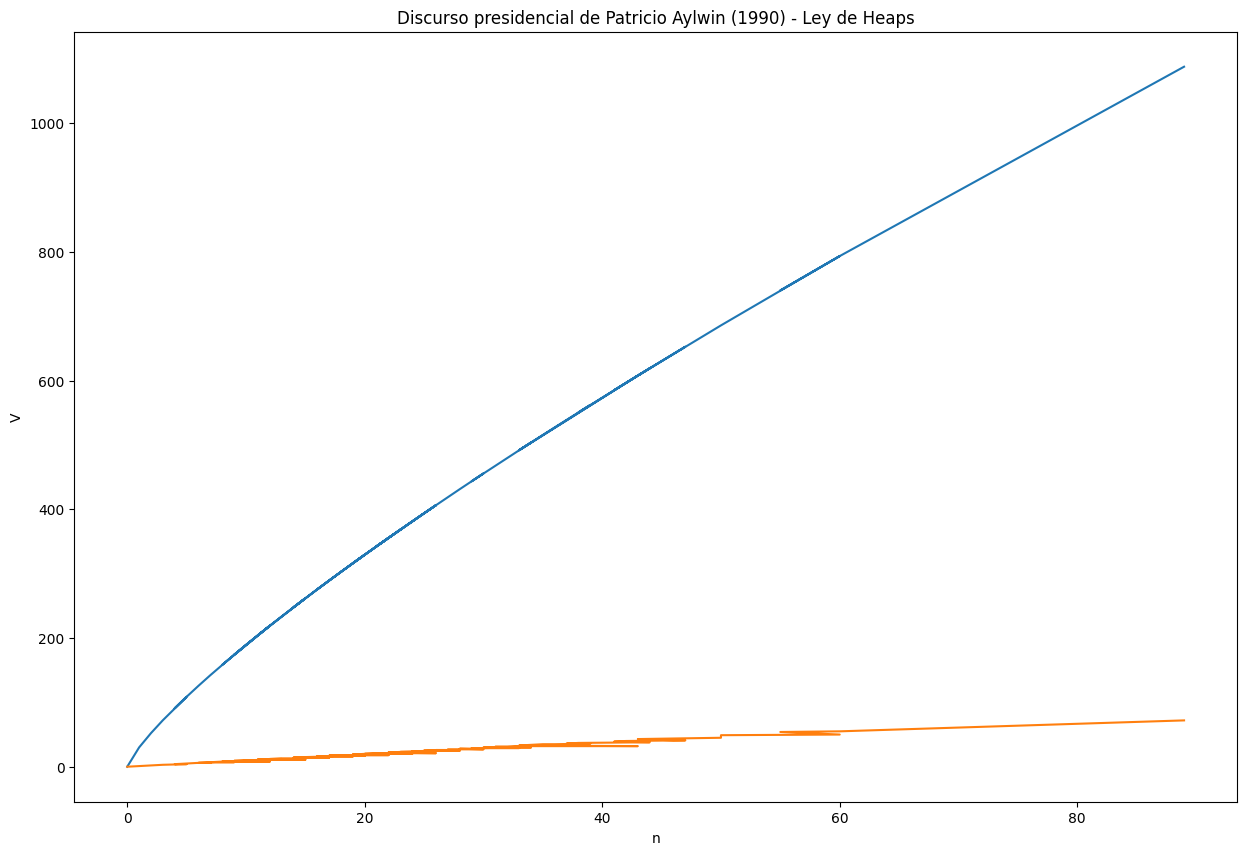

In [24]:
# Gráfico de Ley de Heaps

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(vocabulario_oracion.terminos_totales, vocabulario_oracion.V)
ax.plot(vocabulario_oracion.terminos_totales, vocabulario_oracion.terminos_distintos)


plt.title('Discurso presidencial de Patricio Aylwin (1990) - Ley de Heaps')
plt.xlabel("n")
plt.ylabel("V")

plt.show()

# 7. Conclusiones leyes de Zipf y Heaps

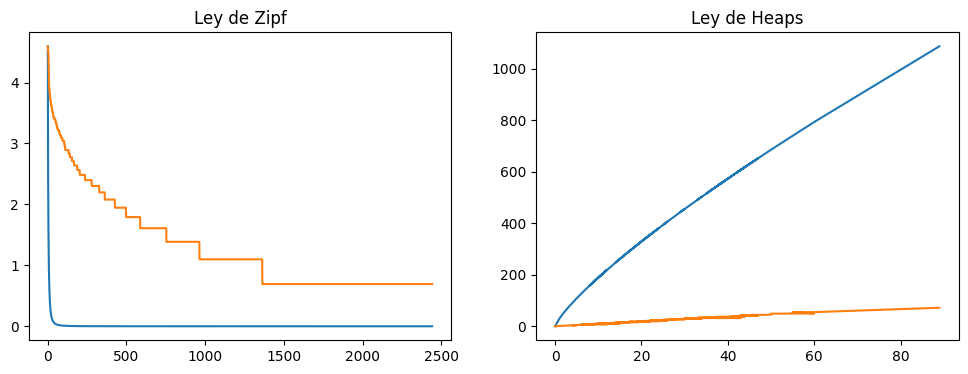

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.plot(vocabulario.ranking, np.log(vocabulario.frecuencia_estimada+1))
ax1.plot(vocabulario.ranking, np.log(vocabulario.frecuencia+1))

ax2.plot(vocabulario_oracion.terminos_totales, vocabulario_oracion.V)
ax2.plot(vocabulario_oracion.terminos_totales, vocabulario_oracion.terminos_distintos)

ax1.set_title('Ley de Zipf')
ax2.set_title('Ley de Heaps')

plt.show()

A partir del gráfico de la Ley de Zipf se estaría observando que el texto no tendría mucha "riqueza" en sus términos, habiendo una distribución "escalonada" que indicaría una distribución muy alejada respecto a la estimada.

En cuanto a la ley de Heaps se estaría observando también la presencia de una distribución que no permitiría una mayor profunidad de análisis o modelamiento, lo que se evidencia en la falta de concavidad en la curva, y sería indicador de una alta presencia de escasez (*scarcity*) debido a una gran cantidad de filas con términos totales iguales a 1 o, en la segmentación del texto escogida, filas donde los términos serían 0 al haberse filtrado todos como *stopwords*.

# 8. Matriz TF-IDF

In [26]:
# Se instancia el modelo para vectorizar

def identity_tokenizer(text):
    return text

tfidf_vect = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False,
                             use_idf=True,
                             ngram_range=(1,1))

tfidf_vect.fit(df_oraciones.contenido_limpio)
tfidf_data = tfidf_vect.transform(df_oraciones.contenido_limpio)

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
tfidf_df=pd.DataFrame(tfidf_data.toarray(), columns=tfidf_vect.get_feature_names())
tfidf_df.shape

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(814, 2441)

In [28]:
tfidf_df.head(5)

,abarc,abarqu,abastec,abiert,abigarr,aboc,abolicion,abord,abriend,abril,...,volumen,volunt,vuelt,vuelv,xxi,yacimient,ydenigr,yfuncional,ypor,zon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Debido a que habrían muchas filas con poca riqueza de texto se no ocupar n-gramas sino palabras sueltas.

# 9. Modelo de Clustering

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


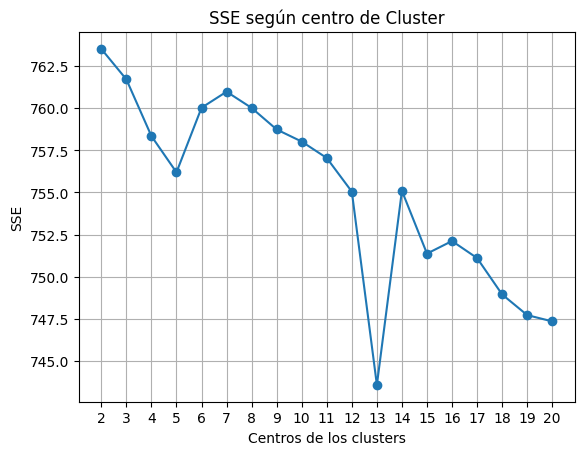

In [29]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k,
                                   init_size=1024,
                                   batch_size=2048,
                                   random_state=20).fit(data).inertia_)
        print(f'Fit {k} clusters')
        
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Centros de los clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE según centro de Cluster')
    
    plt.grid()
    
find_optimal_clusters(tfidf_data, 20)

A partir de lo anterior se identifica que sería 5 el número ideal de clusters, identificándose que por sobre esa cantidad la segmentación empieza a verse muy afectada por la Suma Cuadrática de Errores (*SSE*)

In [30]:
clusters = MiniBatchKMeans(n_clusters=5,
                           init_size=1024,
                           batch_size=2048,
                           random_state=20).fit_predict(tfidf_data)

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sn

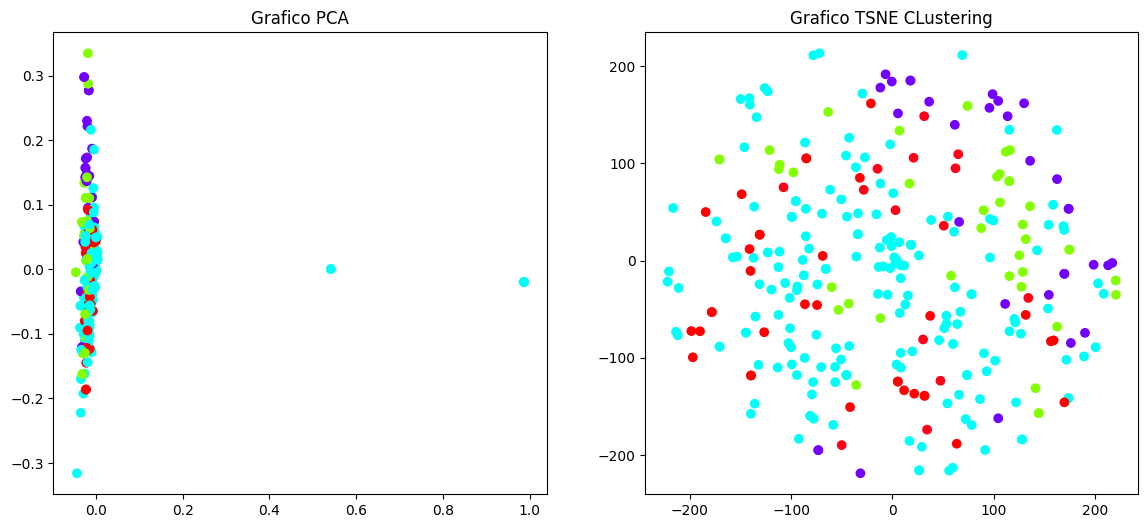

In [31]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('Grafico PCA')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('Grafico TSNE CLustering')
    
plot_tsne_pca(tfidf_data, clusters)

En cuanto a la segmentación de datos se observa que, en consonancia con lo evidenciado a través de las leyes de Zipf y Heaps, la falta de riqueza del texto y la escasez en varias de sus filas ponen en evidencia una distribución no muy separable, como es observado en el gráfico PCA en el que queda evidenciada una marcada agrupación de la distribución.

In [32]:
# Se busca obtener las palabras más frecuentes en cada cluster

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

get_top_keywords(tfidf_data, clusters, tfidf_vect.get_feature_names(), 15)



Cluster 1
motiv,sid,respect,sector,anterior,proyect,insuficient,pais,cient,obras,public,infraestructur,ultim,anos,inversion

Cluster 2
president,social,mejor,fuerz,logr,desarroll,viviend,armad,super,gobiern,import,deb,ser,nacional,polit

Cluster 3
ano,problem,pued,program,trabaj,educacion,eficient,necesari,public,capac,pais,recurs,gobiern,sector,aplaus

Cluster 4
democraci,fuerz,desarroll,social,integracion,gobiern,human,cooperacion,pais,plen,puebl,econom,internacional,derech,chil

Cluster 5
actual,situacion,chilen,tecnolog,pais,hac,progres,mayor,haci,equid,desarroll,avanz,camin,vez,cad


C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Sin embargo los *clusters* sí permiten identificar la correcta identificación de ejes temáticos.

**Cluster 1:** Sobre la situación anterior en dictadura (anterior, insuficiencia, últimos años, invesrsión)

**Cluster 2:** Sobre la vinculación de elementos de la dictadura (fuerzas, armadas, desarrollo, vivienda)

**Cluster 3:** Sobre el desarrollo del sector público (programas, trabajo, educación, recursos)

**Cluster 4:** Sobre la economía en democracia (democracia, integración, gobierno, internacional, derecho)

**Cluster 5:** Sobre las proyecciones de desarrollo en Chile (país, tecnología, progreso, equidad, desarrollo)

# 10. Análisis de sentimientos

In [33]:
# Se carga el léxico afin

lexicon=pd.read_csv('lexico_afinn.en.es.csv', sep=',', encoding='latin1')

In [34]:
# Se aplica una función que asigna un puntaje a cada documento

def sentimiento(cadena):
    # Se cargan los datos del léxico afin en listas
    lexis=' '.join(lexicon.Palabra)
    punct=list(lexicon.Puntuacion)
    
    # Se generan listas vacías
    palabra=[]
    puntaje=[]
    pu=[]
    
    # Se separa cada palabra del documento
    palabras=cadena.split()
    pfinal=np.nan
    
    # Se realiza una iteración sobre cada palabra del documento, calculando el puntaje
    for p in palabras:
        try:
            t=re.search(p,lexis).group()      
            palabra.append(t)
            pu=lexicon[lexicon['Palabra']==t]['Puntuacion'].mean()
            puntaje.append(pu)
            
        except AttributeError:
            continue
            
    # Se calcula la media
    pfinal=np.nanmean(puntaje)
    
    # Se genera un if-else ante casos donde hubieran NaN
    if np.isnan(pfinal)==True:
        pfinal=np.nan_to_num(pfinal)
    else:
        pfinal
    
    return(pfinal)     

In [35]:
# Se vuelve a generar la limpieza, pero esta vez sin lematización con el fin de poder
# observar los resultados con mayor contexto

def limpieza_sin_lematizacion(texto):
    # Transformaciones realizadas:
    
    texto_norm=texto.lower() # conversión a minúsculas
    texto_norm=texto_norm.strip() # eliminación de espacios iniciales y finales
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8") # conversión de codificación de texto
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm) # se mantienen caracteres alfanuméricos
    texto_norm=re.sub('\s',' ', texto_norm) # eliminación de dobles espacios
    texto_norm = word_tokenize(texto_norm) # tokenización del texto
    texto_norm = [token for token in texto_norm if len(token) > 2] # eliminación de textos de largo 2
    
    texto_norm = [word for word in texto_norm if not word in stop_words] # eliminación de stopwords
    
    return(texto_norm)

In [36]:
df_oraciones = df_oraciones.drop(columns=['contenido_limpio'])

df_oraciones['contenido_limpio'] = df_oraciones['contenido_crudo'].apply(lambda x: limpieza_sin_lematizacion(x))

In [37]:
df_oraciones['contenido_limpio_detok']=df_oraciones['contenido_limpio'].map(lambda x: detok.detokenize(x))

In [38]:
df_oraciones

,contenido_crudo,contenido_limpio_detok,n_oracion,contenido_limpio
0,"Legislatura 320ª, Ordinaria\nSesión del Congre...",legislatura ordinaria sesion congreso pleno lu...,1,"[legislatura, ordinaria, sesion, congreso, ple..."
1,MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presid...,mensaje presidencial senor valdes presidente e...,2,"[mensaje, presidencial, senor, valdes, preside..."
2,"\nCon tal propósito, tiene la palabra Su Excel...",tal proposito palabra excelencia presidente re...,3,"[tal, proposito, palabra, excelencia, presiden..."
3,\nEl señor AYLWIN (Presidente de la República)...,senor aylwin presidente republica conciudadano...,4,"[senor, aylwin, presidente, republica, conciud..."
4,\nAunque el texto constitucional vigente no pr...,aunque texto constitucional vigente prescribe ...,5,"[aunque, texto, constitucional, vigente, presc..."
...,...,...,...,...
809,\n¡Que Dios nos ayude!\n-(Aplausos).,dios ayude aplausos,810,"[dios, ayude, aplausos]"
810,\nEl señor VALDÉS (Presidente) En conformidad ...,senor valdes presidente conformidad dispuesto ...,811,"[senor, valdes, presidente, conformidad, dispu..."
811,\nSe levanta la sesión.,levanta sesion,812,"[levanta, sesion]"
812,\n-Se levantó a las 18:42.,levanto,813,[levanto]


In [39]:
df_oraciones['polaridad'] = df_oraciones['contenido_limpio_detok'].apply(lambda x: sentimiento(x))

C:\Users\Martín\AppData\Local\Temp\ipykernel_20080\1123528844.py:29: RuntimeWarning: Mean of empty slice
  pfinal=np.nanmean(puntaje)


In [40]:
display(df_oraciones.polaridad.describe())

count    814.000000
mean       0.308823
std        1.248431
min       -4.000000
25%        0.000000
50%        0.000000
75%        1.250000
max        3.000000
Name: polaridad, dtype: float64

<AxesSubplot:>

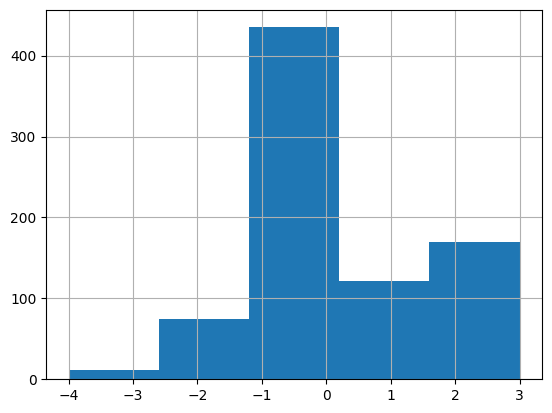

In [41]:
df_oraciones.polaridad.hist(bins=5)

En esta instancia se observaría que, exceptuando los documentos "neutras" (aquellos donde o no se dijo nada asignable a una polaridad negativa/positiva o donde el léxico afin no fue capaz de detectarla) habría una tendencia más cargada hacia lo positivo, lo que se interpreta como algo coherente dentro del contexto de un discurso presidencial, el que estaría orientado hacia resaltar lo positivo.

In [42]:
# Se genera calcula nuevamente una matriz TF-IDF, pero esta vez no ponderada sino binaria

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,
                      ngram_range=(3,3),
                      lowercase=False,
                      max_features=500,
                      binary=True,
                      use_idf=False,
                     norm = None)

tfidf.fit(df_oraciones.contenido_limpio)

tfidf_data = tfidf.transform(df_oraciones.contenido_limpio)

tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=tfidf.get_feature_names())

C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Martín\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
tfidf_df.head()

,acordar prioridades cooperacion,adecuada integracion fuerzas,adhesion orden juridico,administracion justicia eficiente,administrativo politico nacion,aquellos campos estrategicos,arancelarias paraarancelarias acordar,armadas sociedad civil,articulo constitucion politica,avanzada aquellos campos,...,sistema nacional transporte,social chile estudiar,sociedad equitativa exige,toda forma violencia,ultimos dieciseis anos,universidades centros privados,verdad hacer justicia,vias incrementar flujo,vinculos cooperacion instituciones,violaciones derechos humanos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Se confirma que ambas tengan el mismo tamaño (cantidad de filas)

print(len(tfidf_df))
print(len(df_oraciones))

814
814


In [45]:
# Se preparan datos para el modelamiento

# Variable dependiente
mean=df_oraciones.polaridad.mean()
std=df_oraciones.polaridad.std()

label=(df_oraciones[['polaridad']].astype(float)-mean)/std

# Variable independiente
features=tfidf_df

In [46]:
print(mean)
print(std)

0.30882278382278383
1.2484307261542407


In [47]:
label

,polaridad
0,-0.247369
1,1.087641
2,2.155648
3,-1.048374
4,0.353385
...,...
809,1.354642
810,-0.247369
811,-0.247369
812,-0.247369


In [48]:
# Segmentación de muestras para train test

features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split( 
    features,
    label,
    test_size=0.3, 
    random_state = 11
)

In [49]:
# Se instancia regresión lineal

lr = sklearn.linear_model.LinearRegression()
lr.fit(features_train, label_train)

LinearRegression()

In [50]:
# Se generan predicciones

lr_predictions = lr.predict(features_test)

In [51]:
# Se define una función para calcular el MAE (Mean Absolute Error)

def mae(true, predicted):
    error = true-predicted
    absolute_error = np.abs(error)
    return absolute_error.mean()

In [52]:
mae(label_test,lr_predictions)

polaridad    1.435101e+13
dtype: float64

In [53]:
# Se define función para el RMSE (Root Mean Squared Error)

def rmse(true, predicted):
    error = true-predicted
    squared_error = error**2
    return (squared_error.mean())**0.5

In [54]:
rmse(label_test,lr_predictions)

polaridad    4.795399e+13
dtype: float64

In [55]:
def regression_report(y_true, y_pred):
    return {
        'mae': sklearn.metrics.mean_absolute_error(y_true, y_pred),
        'rmse': sklearn.metrics.mean_squared_error(y_true, y_pred)
    }

In [56]:
lr_regression_report = regression_report(label_test, lr_predictions)
lr_regression_report

{'mae': 14351007282972.857, 'rmse': 2.2995846913788935e+27}

In [57]:
# Se obtienen coeficientes de regresión

coefs_score=pd.DataFrame(list(lr.coef_)).T

coefs_score=coefs_score.rename(columns={coefs_score.columns[0]: 'Beta'})
var_tab=pd.DataFrame(features.columns)
var_tab=var_tab.rename(columns={var_tab.columns[0]: 'Var'})
coef_tab=pd.concat([var_tab, coefs_score], axis=1)
coef_tab=coef_tab.sort_values(by=['Beta'], ascending=False).reset_index()
coef_tab.head(20)

,index,Var,Beta
0,33,desarrollo economico social,4.141123e+14
1,17,campos estrategicos desarrollo,2.705437e+14
2,18,chile estudiar mecanismos,2.376290e+14
3,1,adecuada integracion fuerzas,2.093379e+14
4,22,comunidad economica europea,1.832674e+14
5,484,senado camara diputados,1.430148e+14
6,11,avanzar hacia sociedad,1.323478e+14
7,65,intensificar diversificar comercio,1.207106e+14
8,98,normas constitucionales rigen,1.187795e+14
9,264,pais logrado sacrificio,1.094289e+14


In [58]:
# Los 20 términos positivos más importantes

print(coef_tab.head(20))

    index                                 Var          Beta
0      33         desarrollo economico social  4.141123e+14
1      17      campos estrategicos desarrollo  2.705437e+14
2      18           chile estudiar mecanismos  2.376290e+14
3       1        adecuada integracion fuerzas  2.093379e+14
4      22         comunidad economica europea  1.832674e+14
5     484             senado camara diputados  1.430148e+14
6      11              avanzar hacia sociedad  1.323478e+14
7      65  intensificar diversificar comercio  1.207106e+14
8      98       normas constitucionales rigen  1.187795e+14
9     264             pais logrado sacrificio  1.094289e+14
10     28     cooperacion economica entidades  9.775806e+13
11    154         objetivo recursos esperamos  9.215165e+13
12    183             observados promedio dos  9.086544e+13
13     57                 hacia mayor equidad  9.009070e+13
14    235                 oriente africa asia  8.771994e+13
15     38            economica europea c

In [59]:
# Los 20 términos negativos más importantes

print(coef_tab.tail(20))

     index                                    Var          Beta
480     39                 economico social chile -8.970583e+13
481     10                    avanzar hacia mayor -9.009070e+13
482      7                 armadas sociedad civil -1.018128e+14
483    140         nuevos requerimientos economia -1.029723e+14
484     27          cooperacion avanzada aquellos -1.058038e+14
485     29  cooperacion instituciones financieras -1.096450e+14
486    109                 notable progreso visto -1.104899e+14
487     24    concretos intensificar diversificar -1.161517e+14
488     64            integracion fuerzas armadas -1.187795e+14
489    142       numero soluciones habitacionales -1.191566e+14
490    124              nuevas generaciones damos -1.210595e+14
491     67   inversiones promover establecimiento -1.239478e+14
492     58              hacia sociedad equitativa -1.323478e+14
493      9               avanzada aquellos campos -1.338467e+14
494      5           aquellos campos est

Para identificar los términos más importantes positivos y negativos se aumentaron los n-gramas, debido a que de esta manera es posible obtener mayor contexto de cada uno, lo que no fue posible de lograrse a través de términos sueltos.

En lo positivo se evidencian resultados muy claros en lo que son lo identificado como positivo: la presencia de conceptos claves esgrimidos durante la transición como parte del discurso de proyecto país concertacionista: las ideas de desarrollo económico y social, la re-estructuración de los poderes del estado y el vinculamiento económico internacional.

En cuanto a lo negativo, si bien los resultados son algo menos transparentes de identificar, se observa la presencia de ideas más concretas y menos abstractas que aquellas presentes en lo positivo, principalmente ligadas a lo técnico y económico, y particularmente aspectos que se podrían considerar que presentan mayores obstáculos: el vínculo entre las fuerzas armadas y la sociedad civil, la necesidad de soluciones habitacionales, el flujo de inversiones o el aspecto técnico del rol de los sectores de la economía de exportación.